In [166]:
# Data handling and loading
import numpy as np
import pandas as pd
#import datatable as dt
from datetime import datetime, timedelta # To calculate year difference
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from meteostat import Point, Daily, Stations # Weather

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling
#from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
#from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV, cross_val_score
#from xgboost import XGBClassifier
#from sklearn.linear_model import LogisticRegression
import time
# import shap
# from mlxtend.classifier import StackingCVClassifier # ensemble

# warninghandler
import warnings

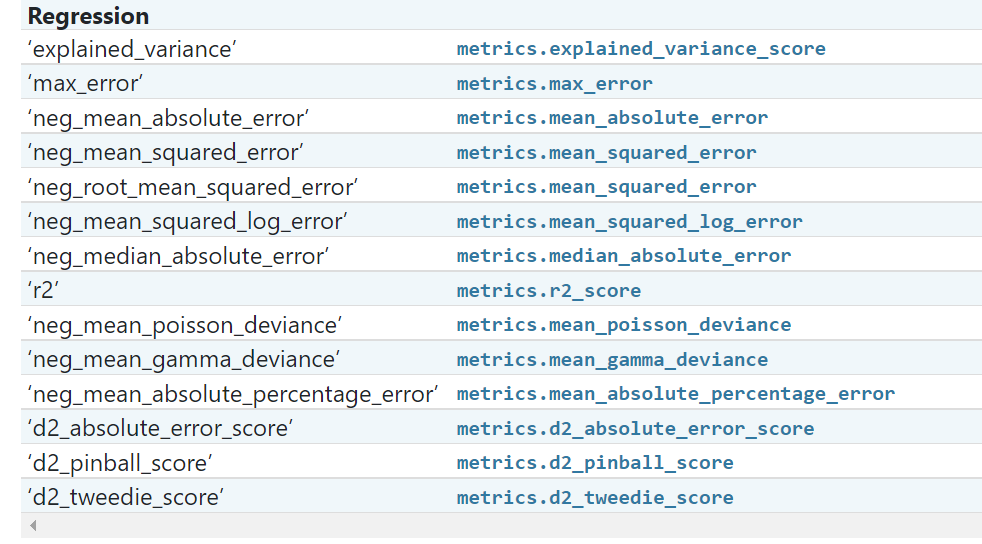

# Read data

In [127]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
stores = pd.read_csv('data/stores.csv')

In [128]:
train.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

# Imputation

In [129]:
missing_values_count = train.isnull().sum()
missing_values_count

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [130]:
train.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

In [75]:
def simple_impute(train_data, all_data, variable_type):
    """
    Simple imputation of missing values in pandas data frame 
    Parameters:
    -----------
    train_data:
        The data we want to use to generate the values that we replace the missing values with.
    all_data:
        All the data that we are replacing the missing values in.
    variable_type:
        The type of variable that we are replacing.
    """
    
    if variable_type == "numeric":
        imputer = SimpleImputer(strategy="mean", missing_values=np.nan)
        selected_data = all_data.select_dtypes(include=np.number)
    elif variable_type == "categorical":
        imputer = SimpleImputer(strategy="most_frequent", missing_values=np.nan)
        selected_data = all_data.select_dtypes(include=np.object)
    else:
        return print("Wrong variable type input")
        
    for (col_name, col_data) in selected_data.iteritems():
        imputer = imputer.fit(train_data[[col_name]])
        all_data[col_name] = imputer.transform(all_data[[col_name]])
    
    return all_data

In [76]:
"""
replacing missing numeric data with mean
"""
train_x = simple_impute(train_x, train_x, "numeric")
val_x = simple_impute(train_x, val_x, "numeric")
test_x = simple_impute(train_x, test_x, "numeric")

"""
replacing missing categorical data with most frequent observation.
"""
train_x = simple_impute(train_x, train_x, "categorical")
val_x = simple_impute(train_x, val_x, "categorical")
test_x

NameError: name 'SimpleImputer' is not defined

# EDA

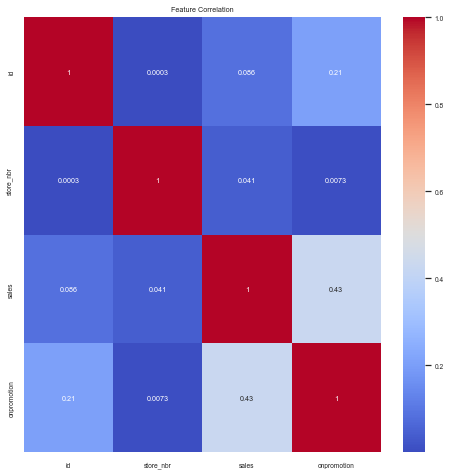

In [77]:
sns.set(font_scale = 0.6)
plt.figure(figsize = (8, 8))
corr_mat = train.corr()

heatmap = sns.heatmap(corr_mat, annot = True, cmap = 'coolwarm')
heatmap.set_title('Feature Correlation')
plt.show()

# Encoding

In [156]:
def encode_data(enc_type, data):
    """
    Encodes the data with the given encoding type. Should be encoded with fitted on train data, but since we do not have
    different levels in train/test this is not needed.
    -----------
    Parameters:
    enc_type: The encoding type, for the moment only onehot encoding is available.
    data: The data that is going to be encoded.
    """
    
    if enc_type == "onehot":
        enc = OneHotEncoder(handle_unknown='ignore')
    elif enc_type == "label":
        return print("Not made label_encoder yet")
    else:
        return print("Unknown encodetype")

    enc_df = pd.DataFrame(enc.fit_transform(data).toarray())
    data_out = enc.transform(data)
    col_names = enc.get_feature_names_out(data.columns)
    data_out = pd.DataFrame(enc_df)
    data_out.columns = col_names

    return data_out

#train_cat = encode_data(enc_type="onehot", data=train.select_dtypes(include=np.object))

#train_encoded = pd.concat([train.select_dtypes(exclude=np.object).reset_index(drop=True), train_cat], axis = 1)
train_encoded = pd.get_dummies(train)

# Data engineering

In [131]:
train['date'] =  pd.to_datetime(train['date'])
train['month'] = pd.to_datetime(train["date"]).dt.month
train['year'] = pd.to_datetime(train["date"]).dt.year
train['week'] = pd.to_datetime(train["date"]).dt.isocalendar().week
train['weekday'] = pd.to_datetime(train["date"]).dt.dayofweek
train['store_nbr'] = train['store_nbr'].astype(str)

In [132]:
train.drop(['id'], inplace=True, axis=1)

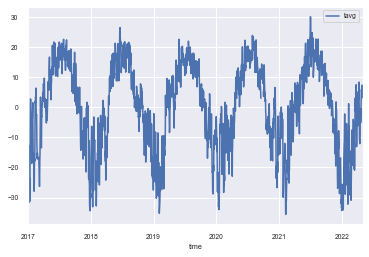

In [124]:
# Set time period
start = datetime(2017, 1, 1)
end = datetime(2022, 4, 30)

# Create Point for Copenhagen (usikkert)
copenhagen = Point(55.67594, 12.56553)

# Get daily data for 2018
daily_weather = Daily(vancouver, start, end)
daily_weather = daily_weather.fetch()

# Plot line chart including average, minimum and maximum temperature
daily_weather.plot(y=['tavg'])
plt.show()

In [123]:
daily_weather

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2010-01-01,1.4,-0.9,3.6,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2010-01-02,1.6,0.6,2.6,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2010-01-03,0.4,-1.3,1.7,0.0,0.0,129.0,3.9,NaN,NaN,NaN
2010-01-04,2.1,0.6,3.6,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2010-01-05,1.2,-2.3,2.8,0.0,0.0,NaN,2.3,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-04-26,6.5,0.6,12.3,0.0,0.0,117.0,4.0,165.6,1017.3,NaN
2022-04-27,7.4,1.3,13.4,0.2,0.0,117.0,4.0,151.2,1019.7,NaN
2022-04-28,4.9,2.3,7.5,0.2,NaN,354.0,3.9,NaN,1017.6,NaN


# Modeling

In [147]:
split = int(len(train) * 0.8)

In [149]:
train_y = train_encoded['sales'][:split]
train_x = train_encoded[:split].drop(['sales', 'date'], axis = 1)
val_y = train_encoded['sales'][split:]
val_x = train_encoded[split:].drop(['sales', 'date'], axis = 1)

## LINREG

In [150]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_x, train_y)

LinearRegression()

In [173]:
val_pre_linreg = model.predict(val_x)

In [174]:
MSE = mean_squared_error(val_pre_linreg, val_y)
r2 = r2_score(val_pre_linreg, val_y)

print("MSE: ", MSE)
print("R^2: ", r2)

MSE:  722459.1348586548
R^2:  0.18924544046934266


# XGBoost

In [155]:
pd.get_dummies(train).shape

(3000888, 94)

In [ ]:
""

In [175]:
from xgboost import XGBRegressor
model = XGBRegressor(enable_categorical=True, use_label_encoder=False)

ModuleNotFoundError: No module named 'xgboost'